In [1]:
#!jupyter nbconvert --to slides week6bonus.ipynb --post serve
# http://127.0.0.1:8000/week6bonus.slides.html?print-pdf

<p style="text-align: center; font-size: 192%"> Computational Finance </p>
<img src="./img/ABSlogo.svg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 90%;">
<p style="text-align: center; font-size: 150%"> Week 6 Bonus: Advanced Monte Carlo Methods </p>
<p style="text-align: center; font-size: 75%"> <a href="#copyrightslide">Copyright</a> </p>

# Weekly Outline: Advanced Monte Carlo Methods
* Variance Reduction Techniques
    * Antithetic Sampling
    * Control Variates
* The Expat Conundrum: Greeks in Monte Carlo

## Reading material

* Hilpisch (2014): Ch. 10 (pp. 287-290)
* Hull (9th, 10th or 11th ed.): Chs. 19, 21.7, 26.8-26.13

# Advanced Monte Carlo Methods
## Variance Reduction Techniques
* In standard Monte Carlo, the length of the confidence interval for $\theta\equiv\mathbb{E}[X]$ is proportional to $\hat{\sigma}/\sqrt{n}$, where $\sigma$ is the standard deviation of $X$.
* Thus to increase the accuracy by a factor of 10 (i.e., gain 1 digit), we need 100 times as many samples.
* Variance reduction techniques aim to improve the accuracy of the estimate, without increasing $n$.
* We will consider two such techniques: *antithetic sampling*, and *control variates*.
* Another powerful technique is *importance sampling*, but this is beyond the scope of this course.

## Antithetic Sampling
* The crude MC estimate for $\theta\equiv \mathbb{E} [X]$, based on $n$ independent draws $X_i$, is
$$
\hat{\theta}\equiv \frac{1}{n}\sum_{i=1}^n X_i.
$$
* Now suppose that we can somehow sample $n$ pairs $(X_i, \tilde X_i)$, such that
  * both $X_i$ and $\tilde X_i$ are drawn from the distribution of $X$;
  * the *pairs* $(X_i, \tilde X_i)$ are independent across $i$;
  * for each $i$, $X_i$ and $\tilde X_i$ are (negatively) correlated.
* The antithetic variable estimator is then
$$
\hat{\theta}_{AV}\equiv \frac{1}{2}\left(\frac{1}{n}\sum_{i=1}^n X_i+\frac{1}{n}\sum_{i=1}^n \tilde X_i\right).
$$

* Rewriting the estimator as
$$
\hat{\theta}_{AV}=\frac{1}{n}\sum_{i=1}^n\left(\frac{X_i+\tilde X_i}{2}\right),
$$
we see that it is unbiased, and that $\hat{\theta}_{AV}$ is the mean of $n$ independent observations $(X_i+\tilde X_i)/2$, so that the LLN and CLT continue to apply.
* Hence, by the CLT,
$$
\sqrt{n}(\hat{\theta}_{AV}-\theta)\stackrel d \rightarrow \mathrm{N}(0,\sigma^2_{AV}),
$$
where

\begin{align*}
\sigma^2_{AV}&\equiv \mathrm{var}\left[\frac{X_i+\tilde X_i}{2}\right]=\frac{1}{4}\left(\mathrm{var}[X_i]+\mathrm{var}[\tilde X_i] +2\mathrm{cov}[X_i,\tilde X_i]\right)\\
%&=\frac{1}{2}\left[\mathrm{var}[X_i] +\mathrm{cov}[X_i,\tilde X_i]\right)
&=\frac{\sigma^2}{2}\big(1+\rho(X_i,\tilde X_i)\big).
\end{align*}

* Comparing the variance of $\hat{\theta}_{AV}$, $\frac{1}{n}\sigma^2_{AV}$, with that of the crude estimator based on $2n$ observations $\left(\frac{1}{2n}\sigma^2\right)$, we see that efficiency is gained whenever the correlation $\rho(X_i,\tilde X_i)$ is negative.
* So how do we draw correlated random numbers $X_i$ and $\tilde X_i$?
* One way is as follows: our simulations are typically based on an array of standard normal random numbers $\mathbf{z}_i$, i.e., $X_i=f(\mathbf{z}_i)$. Setting $\tilde X_i=f(-\mathbf{z}_i)$ will often do the trick. 
* Note for standard Brownian motion, this corresponds to flipping the path about the abscissa.
* Let's modify last week's `bmsim_vec` and `asianmc_vec` to use antithetic sampling:

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=1, av=False):
    """Simulate `numsim` Brownian motion paths. If av=True, then 2*`numsim` paths are returned,
    where paths numsim:2*numsim+1 are the antithetic paths."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(numsim, N+1)
    if av:
        z = np.concatenate((z, -z))  #yields an array of shape (2*numsim,N+1); z stacked on -z
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
    dX[:, 0] = 0.
    X = np.cumsum(dX, axis=1)
    X += X0    
    return tvec, X

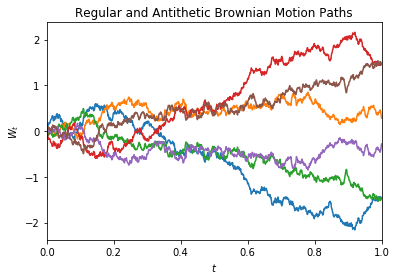

In [4]:
np.random.seed(0) 
tvec, W = bmsim_vec(1, 1000, numsim=3, av=True)
W = pd.DataFrame(W.transpose(), index=tvec)
W.plot().legend().remove()
plt.title('Regular and Antithetic Brownian Motion Paths')
plt.xlabel("$t$"); plt.ylabel("$W_t$");

In [5]:
def asianmc_vec(S0, K, T, r, sigma, q, N, numsim=10000, av=False):
    """Monte Carlo price of an arithmetic average Asian call. 
    Pass `av=True` to use antithetic sampling."""
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2    
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim, av)
    S = np.exp(X)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)
    g = np.exp(-r*T)*payoffs
    if av:
        g = .5*(g[:numsim]+g[numsim:])
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

* Test:

In [6]:
S0 = 11; K = 10; T = 3/12.; r = 0.02; sigma = .3; q = 0.01; N = 10; numsim=10000
np.random.seed(0)
C, Cl, Cu = asianmc_vec(S0, K, T, r, sigma, q, N, numsim, av=False)
C, Cu-Cl

(1.0927262054551385, 0.03592162508407748)

In [7]:
np.random.seed(0)
C, Cl, Cu = asianmc_vec(S0, K, T, r, sigma, q, N, int(numsim/2), True)  #Using int() since some function expect an integer.
C, Cu-Cl

(1.0824190804865295, 0.012604081385357624)

* Not bad. The new interval is about 1/3 as long, with the same amount of work.
* Timings aren't much different:

In [8]:
%timeit asianmc_vec(S0, K, T, r, sigma, q, N, numsim, False)

11.1 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit asianmc_vec(S0, K, T, r, sigma, q, N, int(numsim/2), True)

9.16 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Control Variates
* Antithetic sampling is a general technique that requires little knowledge about the system being simulated.
* Another variance reduction technique is based on *control variates*. It requires a deeper understanding of the problem, but can yield excellent results.
* Suppose again that we want to estimate $\theta\equiv\mathbb{E}[X]$.
* Further suppose that there is another random variable, $Y$, correlated with $X$, with known mean $\mu\equiv\mathbb{E}[Y]$.
* Example: $X$ is the discounted payoff of an option and $\theta$ its unknown price. $Y$ is the discounted payoff of a second option which unlike the first, can be priced analytically.

* Suppose we can draw $n$ pairs $(X_i, Y_i)$, i.i.d. across $i$.  The control variate estimator, for a given constant $c$, is
$$
\hat{\theta}_c\equiv \bar{X}_n-c(\bar{Y}_n-\mu).
$$
* Intuition: suppose $X$ and $Y$ are positively correlated and $c>0$. If, due to sampling variation, $\bar{Y}_n>\mu$ for a given set of replications, then it is likely that also $\bar{X}_n>\theta$, so it should be corrected downwards.
* The estimator is unbiased:
$$
\mathbb{E}[\hat{\theta}_c]=\mathbb{E}[\bar{X}_n]-c\mathbb{E}[\bar{Y}_n-\mu]=\theta.\tag{$\dagger$}
$$
* Let $Z_i\equiv X_i-c(Y_i-\mu)$. Then
$
\hat{\theta}_c=n^{-1}\sum_{i=1}^n Z_i,
$
a sum of $n$ i.i.d. terms, so the LLN and CLT apply. Thus
$$
\sqrt{n}(\hat{\theta}_c-\theta)\stackrel d \rightarrow \mathrm{N}(0,\sigma^2_{CV}),
$$
where $\sigma^2_{CV}\equiv\mathrm{var}(Z_i)$.

* The variance is seen to be

\begin{align*}
\sigma^2_{CV}&\equiv\mathrm{var}(Z_i)=\mathrm{var}\big(X_i-c(Y_i-\mu)\big)\\&=\sigma^2-2c\;\mathrm{cov}(X,Y)+c^2\mathrm{var}(Y).
\end{align*}
* It remains to choose $c$. The optimal $c$ minimizes $\sigma^2_{CV}$, yielding the FOC

$$
0=-2\mathrm{cov}(X,Y)+2c^\ast\mathrm{var}(Y)\quad\Leftrightarrow\quad c^\ast=\frac{\mathrm{cov}(X,Y)}{\mathrm{var}(Y)}.
$$

* With this choice,

\begin{align*}
\sigma^2_{CV}&=\sigma^2-2\frac{\mathrm{cov}^2(X,Y)}{\mathrm{var}(Y)}+\frac{\mathrm{cov}^2(X,Y)}{\mathrm{var}(Y)}\Leftrightarrow\\
\frac{\sigma^2_{CV}}{\sigma^2}&=1-\rho^2(X,Y).
\end{align*}

* We see that the variance is reduced whenever $\rho(X,Y)\neq 0$.
* In practice $c^\ast=\mathrm{cov}(X,Y)/\mathrm{var}(Y)$ is unknown. A consistent estimator is $\hat{c}\equiv S_{X,Y}/S^2_{Y}$, which can be obtained by regressing $X$ on $Y$ and a constant.
* $\hat{c}$ is random and not independent of $Y$. In view of $(\dagger)$, this introduces a bias in $\hat{\theta}_{\hat{c}}$, because we cannot take it out of the expectation. Usually this bias is
small (and disappears asymptotically).
*  The standard errors (and thus the CI) would also need to be adjusted. We just ignore these difficulties.
* The usefulness of the method hinges on the availability of good control variates. A good control variate has $|\rho(X,Y)|$ close to 1, i.e., a strong linear relationship with $X$. It is possible to incorporate several control variates.
* Control variates and antithetic sampling can be combined.

* Classic example: using the geometric average asian call (which can be priced analytically) as a control variate for an arithmetic average call (which cannot).
* The geometric average call has payoff
$$
C^{\mathrm{Geo}}_T=\Big(\prod_{i=1}^N S_{t_i}^{1/N}-K\Big)^+=\Big(\exp\Big\{\tfrac{1}{N}\sum_{i=1}^N X_{t_i}\Big\}-K \Big)^+, \qquad X_t\equiv \log S_t.
$$
* Assuming that $t_i=i\delta t$, it can be shown that 
$$
C^{\mathrm{Geo}}_0=e^{(\hat{\mu}-r)T}S_0\Phi(\hat{d}_1)-e^{-rT}K\Phi(\hat{d}_2),
$$
where

\begin{alignat*}{2}
\hat{d}_1&\equiv\tfrac{\log (S_0/K)+(\hat{\mu}+\frac{1}{2}\hat{\sigma}^2)T}{\hat{\sigma} \sqrt{T}}, \qquad &\hat{d}_2&\equiv\hat{d}_1-\hat{\sigma}\sqrt{T},\\
\hat{\sigma}&\equiv\sigma\sqrt{\tfrac{(N+1)(2N+1)}{6N^2}},\quad\mbox{and }& \hat{\mu}&\equiv\tfrac{\hat{\sigma}^2}{2}+\left(r-q-\frac{\sigma^2}{2}\right)\tfrac{N+1}{2N},
\end{alignat*}
* This is valid only at $t=0$; the general formula is more complicated.

In [10]:
def asiancall_geo(S0, K, T, r, sigma, q, N):
    """Price of a geometric average price asian call."""
    shat = sigma * np.sqrt(((N+1) * (2*N+1)) / (6.0 * N**2))
    mhat = shat**2/2.0 + (r-q-.5*sigma**2) * (N+1)/(2.0*N)
    d1 = (np.log(S0/float(K)) + T*(mhat + 0.5*shat**2)) / shat / np.sqrt(T)
    d2 = d1-shat*np.sqrt(T)
    price = np.exp((mhat-r)*T)*S0*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
    return price

In [11]:
def asianmc_cv(S0, K, T, r, sigma, q, N, numsim=10000):
    """Monte Carlo price of an arithmetic average Asian call using control variates."""
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2    
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
    S = np.exp(X)
    mu = asiancall_geo(S0, K, T, r, sigma, q, N)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)
    control = np.maximum(np.exp(X[:, 1:].mean(axis=1))-K, 0.)
    c = (np.cov(payoffs, control)/np.var(control))[0, 1]  #Select element (0,1) in a (2,2) var/cov-matrix.
    g = np.exp(-r*T)*payoffs - c*(np.exp(-r*T)*control-mu)
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

* Let's try it out:

In [12]:
np.random.seed(0)
C, Cl, Cu = asianmc_cv(S0, K, T, r, sigma, q, 10, numsim)
C, Cu-Cl

(1.0835205424516814, 0.0006064610761988831)

* Wow. Obviously the two payoffs are very highly correlated. 
* Timings:

In [13]:
%timeit asianmc_vec(S0, K, T, r, sigma, q, N, numsim)

10.7 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit asianmc_cv(S0, K, T, r, sigma, q, N, numsim)

13 ms ± 457 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## The Expat Conundrum: Greeks in Monte Carlo
* So far we were mostly concerned with *pricing* options. An equally important problem in practice is *hedging*:
suppose that a financial institution has issued a call option (i.e., it is short the option). In order to eliminate the risk, it might create the hedge
$$
\Pi _{t}\equiv-C_{t}+\phi _{t}S_{t},
$$
where $\phi_{t}$ is a number of stocks. The *delta-hedged* portfolio has
$$
\phi _{t}=\Delta_t\equiv \frac{\partial C_{t}}{\partial S_{t}}.
$$
* This position is *delta-neutral*: it is immune to (infinitesimally) small movements of the underlying.
* The portfolio has to be rebalanced every time the underlying moves (because $\Delta_t$ depends on time), incurring trading costs.

* If there is another instrument on the same underlying available, then it is possible to construct a portfolio that is also *gamma-neutral*. Gamma is defined as
$$
\Gamma_t\equiv \frac{\partial^2 C_{t}}{\partial S^2_{t}}.
$$
Such a portfolio may need to be readjusted less frequently.
* $\Delta_t$ and $\Gamma_t$ are examples of the so-called option *Greeks*. Other examples are $\theta_t$ (the derivative with respect to time), $\rho_t$ (w.r.t. $r$), and $\mathcal{V}_t$ ("Vega", w.r.t. $\sigma$).
* In the BS model, the latter two parameters are constant, but in practice they are not.
* In order to construct a hedge, it is important that we be able to compute the Greeks. This is easy if we have an analytical expression for the price; e.g., for a European call in the BS model, it can be shown
that
$$
\Delta_t=e^{-q(T-t)}\Phi(d_1).
$$
* Chapter 18 of Hull (2012) lists the expressions for the other Greeks.

* If the option cannot be priced analytically, then we may need to resort to Monte Carlo.
* Recalling our risk neutral pricing formula, we see that
$$
\Delta_0=\frac{\partial}{\partial S_0} \mathbb{E}^{\mathbb{Q}}\left[e^{-rT}C_T(S_0)\right].
$$
* In view of the definition of the derivative,
$$
\Delta_0\equiv \lim_{\Delta S_0\rightarrow 0} \frac{\mathbb{E}^{\mathbb{Q}}\left[e^{-rT}C_T(S_0+\Delta S_0)\right]-\mathbb{E}^{\mathbb{Q}}\left[e^{-rT}C_T(S_0)\right]}{\Delta S_0},
$$
it is natural to approximate $\Delta_0$ with a finite difference quotient for some small $\Delta S_0$:

In [15]:
dS = .01 
np.random.seed(0)
Cd, _, _ = asianmc_vec(S0+dS, K, T, r, sigma, q, N, numsim)
C,  _, _ = asianmc_vec(S0,    K, T, r, sigma, q, N, numsim)
Delta = (Cd-C)/dS; Delta

1.5653871014334575

* The true answer is around 0.858.

 * Let's try to improve the approximation by reducing $\Delta S_0$:

In [16]:
dS = .001; np.random.seed(0)
Cd, _, _ = asianmc_vec(S0+dS, K, T, r, sigma, q, N, numsim)
C,  _, _ = asianmc_vec(S0,    K, T, r, sigma, q, N, numsim)
Delta = (Cd-C)/dS; Delta

7.886858496600313

* Ouch. What's happening is that as $\Delta S_0\rightarrow 0$, the sampling variation in $C_T$ increasingly dominates the variation from a small perturbation of $S_0$. This increases the variance of the estimator (which is nevertheless unbiased as $\Delta S_0\rightarrow 0$).
* The trick is to use the same random numbers in both simulation runs: 

In [17]:
dS = .001; np.random.seed(0)
Cd, _, _ = asianmc_vec(S0+dS, K, T, r, sigma, q, N, numsim)
np.random.seed(0)
C,  _, _ = asianmc_vec(S0,    K, T, r, sigma, q, N, numsim)
Delta = (Cd-C)/dS; Delta

0.8622451045858792

* Essentially, this *method of common random numbers* amounts to the approximation
$$
\Delta_0\approx \mathbb{E}^{\mathbb{Q}}\left[\frac{e^{-rT}C_T(S_0+\Delta S_0)-e^{-rT}C_T(S_0)}{\Delta S_0}\right].
$$
* The validity of this approach hinges on whether it is justified to take the limit in the above expression, i.e., whether we may exchange the order of derivative and expectation so that
$$
\frac{\partial}{\partial S_0} \mathbb{E}^{\mathbb{Q}}\left[e^{-rT}C_T(S_0)\right]= \mathbb{E}^{\mathbb{Q}}\left[\frac{\partial}{\partial S_0} e^{-rT}C_T(S_0)\right].
$$

* The approach can be made more explicit. The random variable of interest is
$$
e^{-rT}C_T=e^{-rT}(S_T-K)^+,
$$
where
$$
S_T=S_0e^{(r-q-\sigma^2/2)T+\sigma\sqrt{T}Z},\quad Z\sim N(0,1).
$$
* By the chain rule,
$$
\frac{\partial C_T }{\partial S_0 }=\frac{\partial C_T}{\partial S_T}\frac{\partial S_T}{\partial S_0}.
$$
* We have

$$
\frac{\partial S_T}{\partial S_0}= \frac{S_T}{S_0}\quad\mbox{and}\quad \frac{\partial C_T}{\partial S_T} =\begin{cases}0, &\mbox{if } S_T\lt K\\1, &\mbox{if } S_T\gt K\end{cases}.
$$
* The latter is undefined at $S_T=K$, but this happens with zero probability. Hence
$$
\frac{\partial C_T}{\partial S_0}=\frac{S_T}{S_0} \mathbf{1}_{S_T\gt K}.\tag{$\ddagger$}
$$

* Thus, provided the exchange of derivative and expectation is valid, we have
$$
\Delta_0=\mathbb{E}^{\mathbb{Q}}\left[e^{-rT}\frac{S_T}{S_0} \mathbf{1}_{S_T>K}\right].
$$
* This is called the *pathwise estimate*, because we are keeping the asset path (the random numbers) the same when taking differences / derivatives.
* A similar derivation shows that for the arithmetic average asian call,
$$
\Delta_0=\mathbb{E}^{\mathbb{Q}}\left[e^{-rT}\frac{\bar{S}_T}{S_0} \mathbf{1}_{\bar S_T>K} \right].
$$
This is genuinely useful, as no closed form expression exists.

* Notes:
  * Unlike the simple common-random-numbers approach, the explicit pathwise approach allows us to construct a CI.
  * Also, antithetic sampling and control variates can be used, just like for prices.
  * The validity of the method depends on whether the exchange of derivative and expectation is valid; a necessary condition for this is continuity of the payoff function. Thus, the method fails for, e.g., binary options (note that there, $\partial C_T/\partial S_T=0$ almost everywhere).
  * This also implies that the method cannot be applied to second derivatives such as the option gamma; observe that ($\ddagger$) is discontinuous.  Alternatives include the *likelihood ratio method* (which we won't discuss).

* We apply the method to the arithmetic average Asian option:

In [18]:
def asianmc_delta(S0, K, T, r, sigma, q, N, numsim=10000):
    """Price and Delta of an arithmetic average Asian call."""
    X0 = np.log(S0); nu = r-q-.5*sigma**2    
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
    S = np.exp(X)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)
    deltas = (payoffs > 0)/float(S0)*S[:, 1:].mean(axis=1)
    g1 = np.exp(-r*T)*payoffs
    g2 = np.exp(-r*T)*deltas
    C = g1.mean(); s1 = g1.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s1
    Cu = C + zq/np.sqrt(numsim)*s1
    Delta = g2.mean(); s2 = g2.std()
    Dl = Delta - zq/np.sqrt(numsim)*s2
    Du = Delta + zq/np.sqrt(numsim)*s2
    return C, Cl, Cu, Delta, Dl, Du

In [19]:
np.random.seed(0)
C, Cl, Cu, Delta, Dl, Du = asianmc_delta(S0, K, T, r, sigma, q, N)
print(C, Cl, Cu, Delta, Dl, Du)

1.0927262054551385 1.0747653929130998 1.1106870179971773 0.8622419504514747 0.8548263538144683 0.8696575470884811


* Finally, we combine the pathwise estimate with antithetic sampling and a control variate.
* We'll use the delta of the geometric average call as a control variate. The first step is to modify `asiancall_geo` to also return the delta of the option:

In [20]:
def asiancall_geo2(S0, K, T, r, sigma, q, N):
    """Price and Delta of a geometric average price asian call."""
    shat = sigma * np.sqrt(((N+1) * (2*N+1)) / (6.0 * N**2))
    mhat = shat**2/2.0 + (r-q-.5*sigma**2) * (N+1)/(2.0*N)
    d1 = (np.log(S0/float(K)) + T*(mhat + 0.5*shat**2)) / shat / np.sqrt(T)
    d2 = d1-shat*np.sqrt(T)
    Price = np.exp((mhat-r)*T)*S0*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
    Delta = np.exp((mhat-r)*T)*norm.cdf(d1)
    return Price, Delta

* We'll name the final version of our code `asianMC`.
* To make it easier to use, it returns a [named tuple](https://docs.python.org/2/library/collections.html#collections.namedtuple) containing the simulation results, instead of a bunch of scalars.

In [21]:
from collections import namedtuple
MonteCarloResults = namedtuple("MonteCarloResults", ["Price", "Cl", "Cu", "Delta", "Dl", "Du"])
def asianMC(S0, K, T, r, sigma, q, N, numsim=10000, av=True):
    """Price and Delta of an arithmetic average Asian call using control variates.
    Pass `av=False` to not use antithetic sampling."""
    X0 = np.log(S0); nu = r-q-.5*sigma**2    
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim, av)
    S = np.exp(X)
    mu, D = asiancall_geo2(S0, K, T, r, sigma, q, N)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)
    control1 = np.maximum(np.exp(X[:, 1:].mean(axis=1))-K, 0.)
    deltas = (payoffs > 0)/float(S0)*S[:, 1:].mean(axis=1)
    control2 = (control1 > 0)/float(S0)*np.exp(X[:, 1:].mean(axis=1))
    c1 = (np.cov(payoffs, control1)/np.var(control1))[0, 1]
    c2 = (np.cov(deltas, control2)/np.var(control2))[0, 1]
    g1 = np.exp(-r*T)*payoffs - c1*(np.exp(-r*T)*control1-mu)
    g2 = np.exp(-r*T)*deltas - c2*(np.exp(-r*T)*control2-D)
    if av:
        g1 = .5*(g1[:numsim]+g1[numsim:])    
        g2 = .5*(g2[:numsim]+g2[numsim:])    
    C = g1.mean(); s1 = g1.std(); zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s1
    Cu = C + zq/np.sqrt(numsim)*s1
    Delta = g2.mean(); s2 = g2.std()
    Dl = Delta - zq/np.sqrt(numsim)*s2
    Du = Delta + zq/np.sqrt(numsim)*s2
    return MonteCarloResults(C, Cl, Cu, Delta, Dl, Du)

In [22]:
np.random.seed(0)
results=asianMC(S0, K, T, r, sigma, q, N)
results.Price, results.Delta

(1.083446296903571, 0.8587010833321111)

<section id="copyrightslide">

# Copyright Statement
* Course slides were created by Simon Broda for Python 2.7 $-$ Andreas Rapp adapted them to Python 3.6. Maintained by Bart Keijsers.
* Week 4 slides were created by Bart Keijsers.
* This work is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).
* All figures have been produced for this course using Python. Empirical results are based on public data available from [FRED](https://fred.stlouisfed.org/), [Quandl/WIKI](https://www.quandl.com/databases/WIKIP), and [Yahoo Finance](https://finance.yahoo.com/).
* More information on Simon Broda's [Github](https://github.com/s-broda/ComputationalFinance/blob/master/LICENSE.md).